In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import gzip
from matplotlib import pyplot as plt
import pickle
import torch
from torchvision.utils import make_grid

In [184]:
# with zipfile.ZipFile("../data/2021/2017-01.zip", 'r') as zip_ref:
#     zip_ref.extractall("../data/2021/")

In [2]:
samples_path = "../data/2021/2021-01/"
labeled_path = "../data/2021/2017-01/"


def read_npy_array(path_):
    f = gzip.GzipFile(path_, "r")
    array = np.load(f)
    return array


def read_pkl(path_):
    data = pd.read_pickle(path_)
    return data

def read_sample(base_path, path_, train=True):
    path_to = os.path.join(base_path, path_, "sentinel2-l2a/patches/64x64-10/2021/" if train else "")
    path_to_img = os.path.join(path_to, "data/L2a.npy.gz")
    path_to_mask = os.path.join(path_to, "mask/")
    path_mask_CLD = os.path.join(path_to_mask, "CLD.npy.gz")
    path_mask_CLM = os.path.join(path_to_mask, "CLM.npy.gz")
    path_mask_CLP = os.path.join(path_to_mask, "CLP.npy.gz")
    path_mask_IS_DATA = os.path.join(path_to_mask, "IS_DATA.npy.gz")
    path_mask_SCL = os.path.join(path_to_mask, "SCL.npy.gz")
    path_mask_SNW = os.path.join(path_to_mask, "SNW.npy.gz")
    path_bbox = os.path.join(path_to, "bbox.pkl.gz")
    
    CLD = read_npy_array(path_mask_CLD)
    CLM = read_npy_array(path_mask_CLM)
    CLP = read_npy_array(path_mask_CLP)
    IS_DATA = read_npy_array(path_mask_IS_DATA)
    SCL = read_npy_array(path_mask_SCL)
    SNW = read_npy_array(path_mask_SNW)
    
    img = read_npy_array(path_to_img)
    
    bbox = read_pkl(path_bbox)
    
    return {
        "img": img,
        "bbox": bbox,
        "CLD": CLD,
        "CLM": CLM,
        "CLP": CLP,
        "IS_DATA": IS_DATA,
        "SCL": SCL,
        "SNW": SNW,
    }

mask_list = [
        # "img",
        # "bbox",
        "CLD",
        "CLM",
        "CLP",
        "IS_DATA",
        "SCL",
        "SNW",
]


def show_img(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
def ch_first(img):
    return np.moveaxis(img, -1, 0)

def ch_last(img):
    return np.moveaxis(img, 0, -1)

def stack_channels(img13):
    img13 = ch_first(img13)
    img = ch_last(np.concatenate([img13[3], img13[2], img13[1]], axis=0).reshape(3, 64, 64))
    
    mx = img.max()
    img *= 255 / mx
    
    return img.astype(np.int32)

def stack_3(array):
    return ch_last(np.concatenate([array[0], array[1], array[2]], axis=0).reshape(3, 64, 64))

def build_feature1(img13):
    img13 = ch_first(img13)
    r = (img13[4] + img13[5]) / img13[6]
    g = (img13[2] + img13[3]) / img13[1]
    b = (img13[11] + img13[12]) / img13[7]
    
    img = stack_3([r, g, b])
    
    mx = img.max()
    img *= 255/mx
    
    return img.astype(np.int32)


def build_feature2(img13):
    img13 = ch_first(img13)
    r = img13[2] / img13[1]
    g = (img13[2] + img13[3]) / img13[1]
    b = (img13[5] + img13[6]) / img13[4]
    
    img = stack_3([r, g, b])
    
    mx = img.max()
    img *= 255/mx
    
    return img.astype(np.int32)

def show_timestamp(timestamp, ch=1):
    for img in timestamp:
        plt.figure(figsize=(8, 8))
        plt.imshow(ch_first(img)[0]*255)

In [3]:
samples = os.listdir("../data/2021/2021-01/")
label_samples = os.listdir("../data/2021/2017-01/")


sample = read_sample(labeled_path,  label_samples[0], False)

img = sample["img"]

sample.keys()

cld = sample["SNW"]
cld.shape

# print(cld.min(), cld.mean(), cld.max())

c = sample["bbox"]


p = c.wkt
dir(c)
print(c.min_x, c.min_y, c.max_x, c.max_y)

# for x in mask_list:
#     show_timestamp(sample[x])
    # print(sample[x].shape)

# for x in range(img.shape[0]):
#     # feature = build_feature1(img[x])
#     # show_img(feature)
#     show_img(ch_first(cld[x])[0])

# for x in range(img.shape[0]):
#     show_img(stack_channels(img[x]))

74.44956331395248 63.02904804600002 74.46210459688555 63.03484056516876


In [7]:
reestr = pd.read_excel("../data/Reestr-ZZ-na-18.05.2021.xlsx")

In [8]:
data = reestr

In [9]:
coords = data["Координаты загрязненного участка (в географической системе координат)"]

In [10]:
data.columns

Index(['Корректировка реестра', 'Unnamed: 1', 'Предприятие',
       'Лицензионный участок', 'Unnamed: 4',
       'Вид приоритетного загрязняющего вещества',
       'Регистрационный номер загрязненного участка (предприятия)',
       'Регистрационный номер загрязненного участка в Реестре',
       'Старые регистрационные номера (примечание)',
       'Местоположение загрязненного участка', 'Административный район',
       'Координаты загрязненного участка (в географической системе координат)',
       'Unnamed: 12', 'Дата регистрации в Реестре',
       'Дата факта последнего разлива', 'Акт технического расследования ',
       'Unnamed: 16', 'Категория земель до загрязнения',
       'Наличие специальных защитных зон', 'Площадь загрязненного участка, га',
       'Уровень загрязнения почв и земель нефтью,  нефтепродуктами, мг/кг ',
       'Уровень содержания нефти, нефтепродуктов в донных отложениях водных объектов, мг/кг;  уровень содержания нефти, нефтепродуктов в поверхностных водах, мг/куб

In [11]:
coords = pd.DataFrame()
coords["latitude"] = data["Unnamed: 12"]
coords["longitude"] = data["Координаты загрязненного участка (в географической системе координат)"]
coords["date"] = data["Дата факта последнего разлива"]

In [391]:
# coords[:50]

In [12]:
import re


def is_dms(dms):
    pass

def dms_to_dd(dms):
    try:
        x = float(dms.replace(",","."))
        return x
    except:
        try:
            result = re.findall(r"[\d]+[,\.]?\d*", dms)
            return int(result[0])+int(result[1])/60+float(result[2].replace(",","."))/(60*60)
        except Exception:
            return None

counter = 0

# def dms_to_dd(dms):
#     try:
#         result = re.findall(r"[\d]+[,\.]?\d*", dms)
#         return int(result[0])+int(result[1])/60+float(result[2].replace(",","."))/(60*60)
#     except Exception:
#         pass

    
# for i in range(2, len(coords)):
#     lat = dms_to_dd(coords.iloc[i][0])
#     lon = dms_to_dd(coords.iloc[i][1])
    
print(counter)

0


In [10]:
lats, lons, dates = [], [], []

for i in range(2, len(coords)):
    lat = dms_to_dd(coords.iloc[i][0])
    lon = dms_to_dd(coords.iloc[i][1])
    dat = coords.iloc[i][2]
    if lat and lon:
        lats.append(lat)
        lons.append(lon)
        dates.append(dat)

In [11]:
new_coords = pd.DataFrame()
new_coords["lat"] = lats
new_coords["lon"] = lons
new_coords["date"] = dates
new_coords

,lat,lon,date
0,62.592583,73.506833,1905-07-08 00:00:00
1,62.543500,73.508194,1905-07-08 00:00:00
2,62.616667,73.347778,1905-07-10 00:00:00
3,62.557611,73.547472,2019
4,62.129353,73.983397,2019
...,...,...,...
6994,61.020556,79.595556,23.08.2020\n12:50
6995,61.035278,79.585278,23.08.2020\n17:00
6996,61.061111,79.659722,26.08.2020\n09:45
6997,61.316889,77.539306,18.03.2020


In [12]:
def compare(x: float, y: float):
    return x - y < 1e-4

def collect_all_paths(root="../data/2021/oilroad"):
    
    objects = []
    
    for elem in os.listdir(root):
        cur = os.path.join(root, elem)
        if os.path.isdir(cur):
            objects += collect_all_paths(cur)
        else:
            if elem == "bbox.pkl.gz":
            # if "zip" in elem:
                objects.append(cur)
                # print(
                
                #     read_npy_array(os.path.join(root, "data/L2a.npy.gz")).shape
                # )
                return objects
                
    return objects

In [14]:
# paths = collect_all_paths()

len(new_coords)

6999

In [409]:
# for z in paths:
#     with zipfile.ZipFile(z, 'r') as zip_ref:
#         zip_ref.extractall("../data/2021/oilroad/")

In [15]:
pk = read_pkl("../data/2021/2017-01/ÅÅ-2013-100/timestamp.pkl.gz")

In [16]:
pk

[datetime.datetime(2017, 1, 28, 6, 31, 18, tzinfo=tzlocal()),
 datetime.datetime(2017, 3, 9, 6, 30, 10, tzinfo=tzlocal()),
 datetime.datetime(2017, 4, 15, 6, 16, 30, tzinfo=tzlocal()),
 datetime.datetime(2017, 6, 14, 6, 16, 30, tzinfo=tzlocal()),
 datetime.datetime(2017, 7, 7, 6, 30, 17, tzinfo=tzlocal()),
 datetime.datetime(2017, 7, 31, 6, 6, 33, tzinfo=tzlocal()),
 datetime.datetime(2017, 8, 1, 6, 27, 39, tzinfo=tzlocal()),
 datetime.datetime(2017, 8, 31, 6, 30, 12, tzinfo=tzlocal()),
 datetime.datetime(2017, 11, 14, 6, 31, 20, tzinfo=tzlocal())]

In [17]:
from tqdm.notebook import tqdm

def get_dd_from_bbox(bbox):
    return (bbox.min_y + bbox.max_y)/2, (bbox.min_x + bbox.max_x)/2, 

def get_box(bbox):
    return bbox.min_y, bbox.max_y, bbox.min_x, bbox.max_x


def compare_t(a, b):
    # print(a, b)
    delta = 1e-3
    return abs(a[0] - b[0])<delta and abs(a[1] - b[1])<delta

def compare_in(a, b):
    return a[0] <= b[0] <= a[1] and a[2] <= b[1] <= a[3]


matches = []

pkls = []

for p in paths:
        try:
            pk = read_pkl(p)
            # cor_pk = get_dd_from_bbox(pk)
            cor_pk = get_box(pk)
            pkls.append([cor_pk, p])
        except Exception:
            pass

for cor in tqdm(new_coords.values):
    cor_t = (cor[0], cor[1])
    for cor_pk in pkls:
        # if compare_t(cor_pk[0], cor_t):
        if compare_in(cor_pk[0], cor_t):
            index_of_day = 0
            matches.append((cor_pk[1], cor[2]))
    
    
print(len(matches))

NameError: name 'paths' is not defined

In [414]:
print(matches[0])

('../data/2021/oilroad\\2021-07\\7d253c9b-b3a4-4556-a1a2-4ee6b3e65ff2\\sentinel2-l2a\\patches\\64x64-10\\2021\\bbox.pkl.gz', '23.04.2020\n07.05.2020')


In [417]:
# list(new_coords["date"].unique())

In [512]:
import datetime

def to_normal_date(date):
    if type(new_coords.values[0][2]) == type(date):
        return date.day, date.month
    
    if type(date) == int:
        return 1, 1
    
    try:
        arr =  re.findall(r"\d+", date)
    except Exception:
        return 1, 1
    
    d, m = 1, 1
    if len(arr) > 2:
        for i in range(len(arr)):
            if len(arr[i]) == 4:
                d = arr[i - 2]
                m = arr[i - 1]
                break
            
    return d, m
            
        

In [513]:
to_normal_date(new_coords.values[0][2])

(8, 7)

In [514]:
ds = []

for x in tqdm(new_coords.values):
    ds.append(to_normal_date(x[2]))
    
    
len(ds)

  0%|          | 0/6999 [00:00<?, ?it/s]

6999

In [515]:
# new_coords["dm"]=ds

In [21]:
paths = [os.path.join(*(x[0].split("\\")[:-1])) for x in matches]
date_n = [tuple(map(int, to_normal_date(x[1]))) for x in matches]

day_idx = []

In [22]:
def get_closest_date_idx(ds, date_t_l):
    idx = 0
    dd = None
    dx = datetime.timedelta(days=1000)
    for i, date in enumerate(date_t_l):
        n_d = datetime.datetime(2021, date.month, date.day)
        # print(ds)
        if ds[1] == 2:
            ds = (min(28, ds[0]), 2)
        if datetime.datetime(2021, ds[1], ds[0], tzinfo=None) - n_d < dx:
            dx = datetime.datetime(2021, ds[1], ds[0], tzinfo=None) - n_d
            idx = i
            dd = ds[1], ds[0]
            
    return idx, dd
        

dm_dat = []
    
for i in range(len(paths)):
    dts = read_pkl(os.path.join(paths[i], "timestamp.pkl.gz"))
    idx = get_closest_date_idx(date_n[i], dts)
    day_idx.append(idx[0])
    dm_dat.append(idx[1])
    # for j, x in enumerate(dts):
        
        # if (x.day, x.month) == date_n[i]:
        #     day_idx.append(j)
        #     break

In [570]:
len(day_idx)

1360

In [23]:
dataset = pd.DataFrame()
img_a = []
lat_x = []
lon_x = []
bbox_x = []
date = dm_dat

for i in tqdm(range(len(day_idx))):
    imgs = read_npy_array(os.path.join(paths[i], "data/L2A.npy.gz"))
    bb = read_pkl(os.path.join(paths[i], "bbox.pkl.gz"))
    box = get_dd_from_bbox(bb)
    lat_x.append(box[0])
    lon_x.append(box[1])
    bbox_x.append(bb)
    img_a.append(imgs[day_idx[i]])
    
dataset["image"] = img_a
dataset["lat"] = lat_x
dataset["lon"] = lon_x

0it [00:00, ?it/s]

In [24]:
dataset["date"] = dm_dat
dm_dat[121]

IndexError: list index out of range

In [13]:
s = 121
img = dataset.values[s][0]

NameError: name 'dataset' is not defined

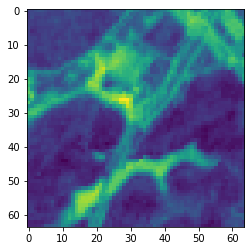

In [605]:
plt.imshow(img[:, :, 1])

In [576]:
dataset.values[s][1], dataset.values[s][2]

(60.443349099766834, 72.17131877158687)

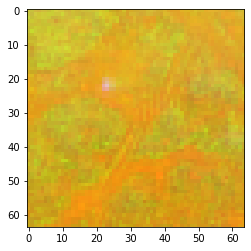

In [577]:
plt.imshow(build_feature1(img))

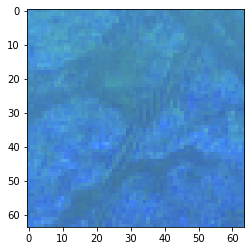

In [578]:
plt.imshow(build_feature2(img))

In [579]:
bbox_x[s].wkt

'POLYGON ((72.16576044469464 60.44035609252692, 72.16576044469464 60.44634210700676, 72.17687709847911 60.44634210700676, 72.17687709847911 60.44035609252692, 72.16576044469464 60.44035609252692))'

In [580]:
dataset.values[s][3]

(2, 7)

In [631]:
with open('data.p', 'rb') as fp:
    data = pickle.load(fp)

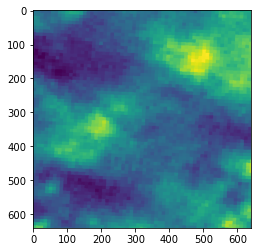

In [632]:
plt.imshow(data["B03"])

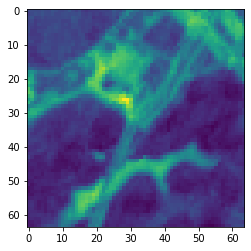

In [ ]:
plt.imshow(img)

In [ ]:
def resize64():


a = []
for layer in list(data.keys())[:13]:
    a.append(data.get(layer))
    
a=np.array(a)

IndentationError: expected an indented block (Temp/ipykernel_2464/22293589.py, line 3)

In [636]:
# plt.imshow(stack_channels(a))

In [635]:
dataset[:1]

,image,lat,lon,date
0,"[[[5.302, 7.148, 6.836, 6.94, 6.954, 7.161, 7....",60.874022,77.064921,"(4, 23)"
